In [1]:
%matplotlib inline

import sys
sys.path.append("..")

from src.regime_trading_pipeline import RegimeRotationStrategy
from src.performance_toolkit import RegimePerformanceToolkit

## Fit WK-means Model and Build Returns

In [2]:
growth = [
    "IWP",   # iShares Russell Mid-Cap Growth ETF
    "IWY",   # iShares Russell Top 200 Growth ETF
    "QUAL",  # iShares MSCI USA Quality Factor ETF
    "QQQ",   # Invesco QQQ Trust (Nasdaq-100)
    "RPG",   # Invesco S&P 500 Pure Growth ETF
    "SCHG",  # Schwab U.S. Large-Cap Growth ETF
    "SCHM",  # Schwab U.S. Mid-Cap ETF
    "VBK",   # Vanguard Small-Cap Growth ETF
    "VGT",   # Vanguard Information Technology Index Fund ETF
    "VUG",   # Vanguard Growth ETF
]

# Retrieved from https://www.simplysafedividends.com/world-of-dividends/posts/939-20-best-recession-proof-dividend-stocks-for-a-2025-downturn
defensive = [
    "BMY",  # Bristol-Myers Squibb Co. (pharmaceuticals)
    "CL",   # Colgate-Palmolive Co. (consumer staples – personal care)
    "CVX",  # Chevron Corp. (integrated oil & gas)
    "DUK",  # Duke Energy Corp. (regulated electric utility)
    "ED",   # Consolidated Edison, Inc. (regulated utility)
    "EPD",  # Enterprise Products Partners L.P. (midstream energy MLP)
    "GIS",  # General Mills, Inc. (packaged foods)
    "GPC",  # Genuine Parts Co. (industrial/auto parts distributor)
    "JNJ",  # Johnson & Johnson (healthcare & consumer health)
    "KMB",  # Kimberly-Clark Corp. (tissue & hygiene products)
    "KO",   # Coca-Cola Co. (beverages)
    "LMT",  # Lockheed Martin Corp. (defense & aerospace)
    "MCD",  # McDonald's Corp. (global quick-service restaurants)
    "O",    # Realty Income Corp. (net-lease REIT, “monthly dividend”)
    "PEP",  # PepsiCo, Inc. (snacks & beverages)
    "PG",   # Procter & Gamble Co. (household & personal products)
    "PSA",  # Public Storage (self-storage REIT)
    "VZ",   # Verizon Communications Inc. (telecom)
    "WEC",  # WEC Energy Group, Inc. (regulated utility)
    "XOM",  # Exxon Mobil Corp. (integrated oil & gas)
]

strategy = RegimeRotationStrategy(
    growth_tickers=growth,
    defensive_tickers=defensive,
    start_date="2019-05-09",  # 5 yrs data (post covid)
    p_dim=2,                  # W2 distance
    window=360,               # approx. 15 days hourly return
    step=12,                  # half a day
    refit_every=96,           # refit MK-means every 48 days
    shift=True,               # avoid using future information
    # max_label_gap=10,         # smoothing transient gap between regimes
)

strategy.fit_kmeans()
strategy.build_returns()

## Backtest

### Aggressive Strategy

In [3]:
aggressive = strategy.backtest(
    allocations={
        0: {"growth": 1.0, "defensive": 0.0},
        1: {"growth": 0.5, "defensive": 0.5},
        2: {"growth": 0.0, "defensive": 1.0},
    },
)

toolkit = RegimePerformanceToolkit(aggressive)
toolkit.show_basic_info()

Start date: 2020-10-30
End date:   2025-10-31
Duration:   1827 

# of points in cluster 0 : 680
# of points in cluster 1 : 362
# of points in cluster 2 : 215


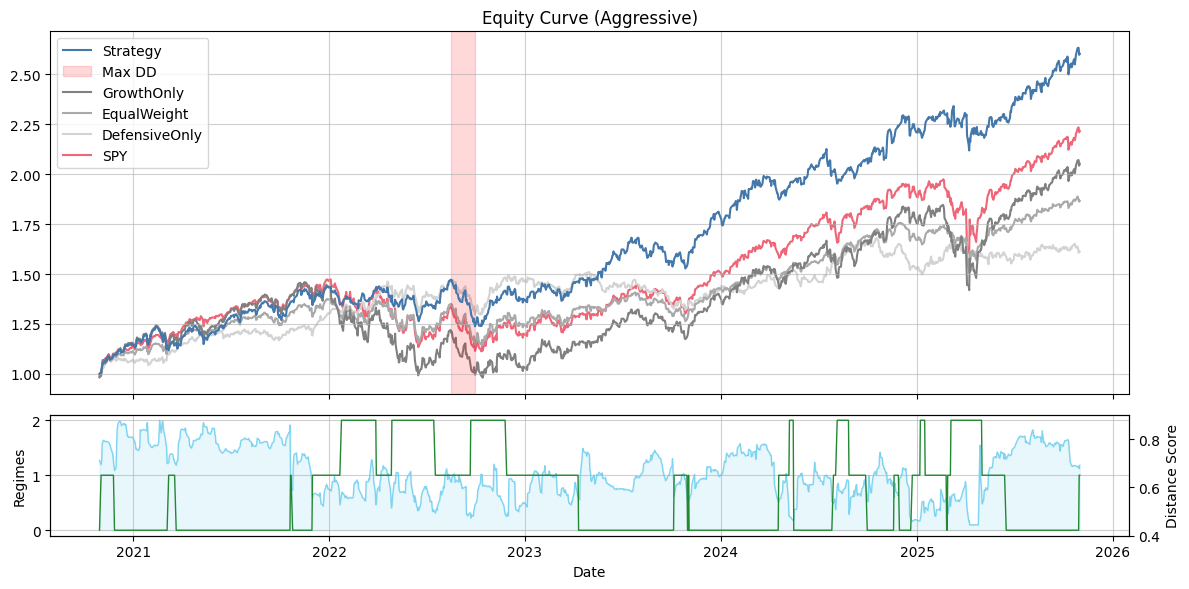

In [4]:
toolkit.plot_equity_curves("Aggressive")

In [5]:
toolkit.summary_table()

,cumulative_return,annual_return,annual_vol,sharpe,sortino,max_drawdown,hit_rate,avg_up_day,avg_down_day,skew,kurtosis
Strategy,160.4117%,21.1705%,14.8879%,1.421990,1.989952,-15.8992%,55.8917%,0.7130%,-0.7207%,-0.420283,1.308765
GrowthOnly,109.0407%,15.9445%,21.1775%,0.752898,1.052417,-32.8144%,53.9013%,0.9567%,-0.9719%,0.138301,5.429348
EqualWeight,88.5019%,13.5634%,13.9890%,0.969576,1.343231,-16.7465%,54.2197%,0.6327%,-0.6306%,0.002943,5.626736
DefensiveOnly,61.5177%,10.0973%,12.1813%,0.828916,1.206130,-12.5564%,53.8217%,0.5756%,-0.5818%,-0.213033,1.980087
SPY,124.0520%,17.5690%,17.1522%,1.024298,1.410223,-24.4964%,54.6975%,0.7628%,-0.7690%,0.288859,9.017801


In [6]:
toolkit.average_holding_period()

,avg,min,max,count
holding_periods,,,,
"G=1.0, D=0.0",56.67,1,149,12
"G=0.5, D=0.5",20.06,1,91,18
"G=0.0, D=1.0",30.71,6,54,7


In [7]:
toolkit.monthly_returns_table()

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
year,,,,,,,,,,,,,
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3778%,5.0948%,14.9504%
2021,-0.3734%,1.7573%,-0.6913%,5.6686%,-1.0908%,5.5025%,2.4709%,3.4631%,-5.2414%,7.8226%,-0.7059%,4.4947%,24.7688%
2022,-4.0732%,-0.7623%,3.9653%,-4.8451%,2.0365%,-2.6071%,5.7179%,-3.2722%,-9.8216%,10.2783%,5.1566%,-4.4566%,-4.3800%
2023,4.1891%,-2.1117%,3.8118%,1.8808%,2.4835%,7.0467%,3.6623%,-1.8797%,-5.3219%,-0.8455%,9.7157%,5.9501%,31.3505%
2024,1.0917%,6.6103%,2.3802%,-4.6368%,3.0173%,4.3277%,-0.5741%,0.5331%,2.1010%,-0.3393%,8.4422%,-1.6060%,22.7300%
2025,2.7193%,0.3751%,1.2321%,-3.9272%,2.3635%,3.9562%,2.6614%,1.5595%,3.5180%,2.2768%,NaN,NaN,17.7913%


In [8]:
toolkit.drawdown_table(top_n=5)

,start,trough,recovery,depth,time_to_trough,recovery_days,duration
rank,,,,,,,
34,2022-08-17,2022-09-30,2023-04-13,-15.8992%,44,195.0,239.0
32,2022-04-05,2022-06-17,2022-08-10,-12.2002%,73,54.0,127.0
16,2021-02-16,2021-03-08,2021-04-26,-9.5095%,20,49.0,69.0
78,2025-03-11,2025-04-08,2025-06-27,-9.5020%,28,80.0,108.0
48,2023-08-01,2023-10-27,2023-11-20,-9.1840%,87,24.0,111.0


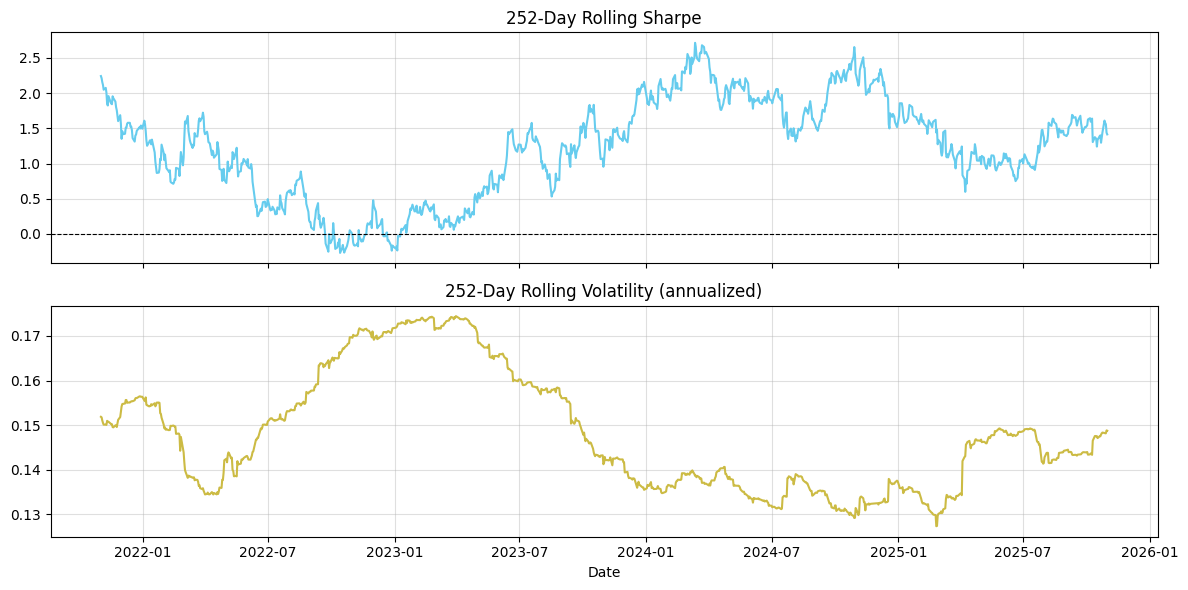

In [9]:
toolkit.plot_rolling_metrics(252)

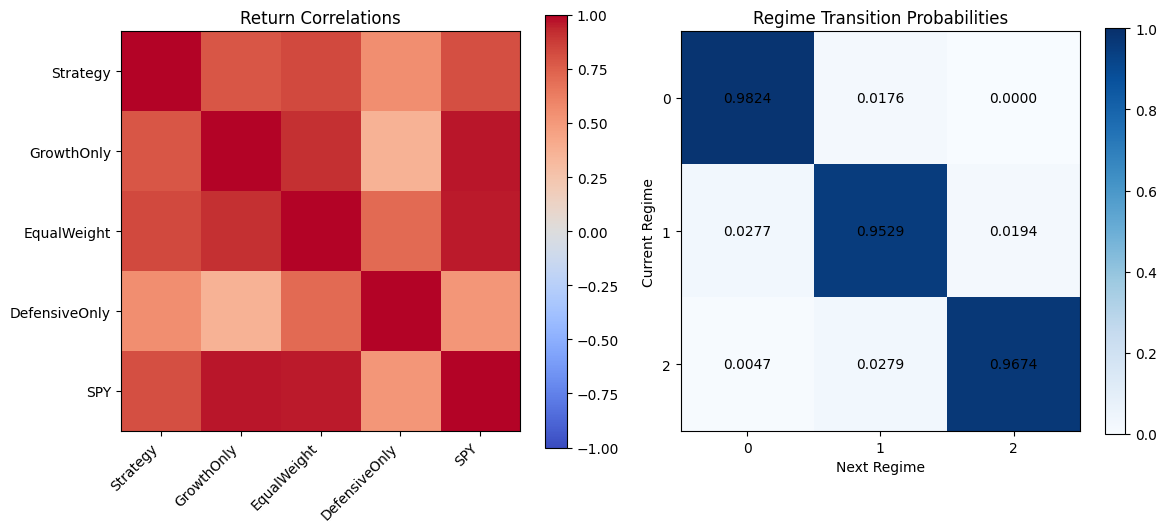

In [10]:
toolkit.plot_correlation_and_transitions()

### Conservative Strategy

In [11]:
conservative = strategy.backtest(
    allocations={
        0: {"growth": 1.0, "defensive": 0.0},
        1: {"growth": 0.0, "defensive": 1.0},
        2: {"growth": 0.0, "defensive": 1.0},
    },
)

toolkit = RegimePerformanceToolkit(conservative)
toolkit.show_basic_info()

Start date: 2020-10-30
End date:   2025-10-31
Duration:   1827 

# of points in cluster 0 : 680
# of points in cluster 1 : 362
# of points in cluster 2 : 215


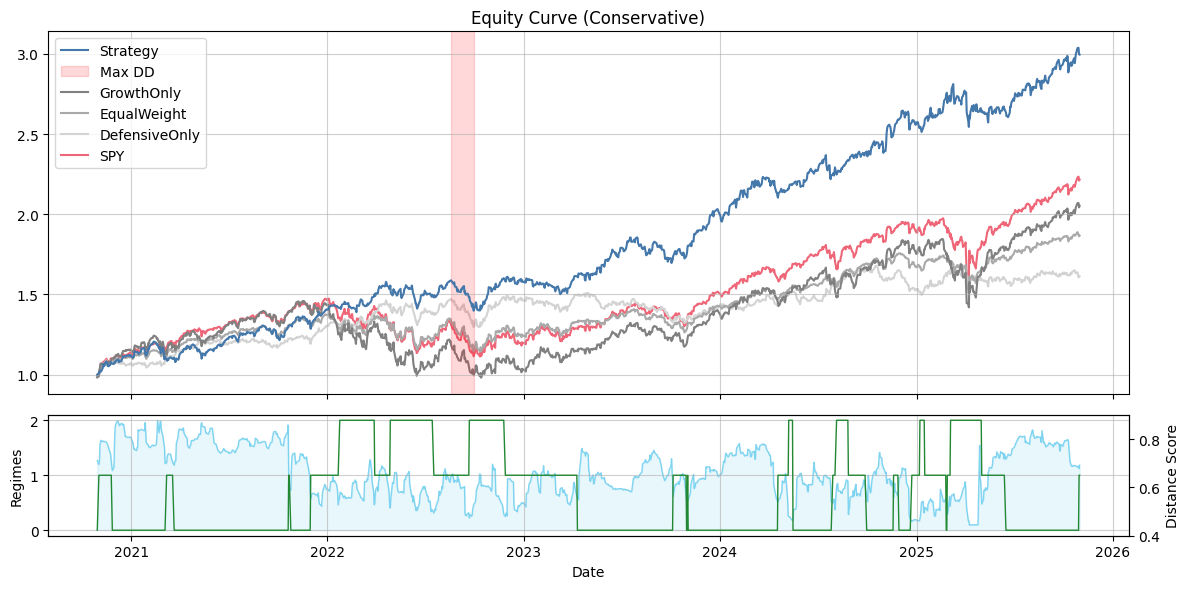

In [12]:
toolkit.plot_equity_curves("Conservative")

In [13]:
toolkit.summary_table()

,cumulative_return,annual_return,annual_vol,sharpe,sortino,max_drawdown,hit_rate,avg_up_day,avg_down_day,skew,kurtosis
Strategy,199.6152%,24.6282%,14.4250%,1.707330,2.387720,-11.9491%,56.2102%,0.6974%,-0.6861%,-0.406832,1.473829
GrowthOnly,109.0407%,15.9445%,21.1775%,0.752898,1.052417,-32.8144%,53.9013%,0.9567%,-0.9719%,0.138301,5.429348
EqualWeight,88.5019%,13.5634%,13.9890%,0.969576,1.343231,-16.7465%,54.2197%,0.6327%,-0.6306%,0.002943,5.626736
DefensiveOnly,61.5177%,10.0973%,12.1813%,0.828916,1.206130,-12.5564%,53.8217%,0.5756%,-0.5818%,-0.213033,1.980087
SPY,124.0520%,17.5690%,17.1522%,1.024298,1.410223,-24.4964%,54.6975%,0.7628%,-0.7690%,0.288859,9.017801


In [14]:
toolkit.average_holding_period()

,avg,min,max,count
holding_periods,,,,
"G=1.0, D=0.0",56.67,1,149,12
"G=0.0, D=1.0",48.00,1,340,12


In [15]:
toolkit.monthly_returns_table()

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
year,,,,,,,,,,,,,
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.6969%,5.0948%,12.1330%
2021,-0.3734%,1.7573%,-2.5814%,5.6686%,-1.0908%,5.5025%,2.4709%,3.4631%,-5.2414%,7.8258%,-0.7059%,7.1295%,25.4838%
2022,2.3429%,-0.7623%,4.2637%,1.3044%,2.0365%,-2.6071%,3.4532%,-2.2100%,-7.8648%,10.2783%,4.2037%,-1.6254%,12.3308%
2023,-0.4425%,-2.7023%,3.0744%,3.4223%,2.4835%,7.0467%,3.6623%,-1.8797%,-5.3219%,1.2979%,9.1317%,5.9501%,27.7765%
2024,1.0917%,6.6103%,2.3802%,-4.0986%,1.8102%,4.3277%,-1.2569%,5.0867%,1.5280%,-0.3393%,8.6947%,-0.6654%,27.4147%
2025,1.1166%,4.4703%,1.9470%,-3.9272%,0.1591%,2.0675%,2.6614%,1.5595%,3.5180%,1.9910%,NaN,NaN,16.4323%


In [16]:
toolkit.drawdown_table(top_n=5)

,start,trough,recovery,depth,time_to_trough,recovery_days,duration
rank,,,,,,,
38,2022-08-22,2022-09-30,2022-11-22,-11.9491%,39,53.0,92.0
13,2021-02-16,2021-03-24,2021-06-24,-10.6113%,36,92.0,128.0
37,2022-04-21,2022-06-17,2022-08-16,-10.5788%,57,60.0,117.0
93,2025-03-11,2025-04-08,2025-07-25,-9.5020%,28,108.0,136.0
57,2023-08-01,2023-10-03,2023-11-14,-8.6106%,63,42.0,105.0


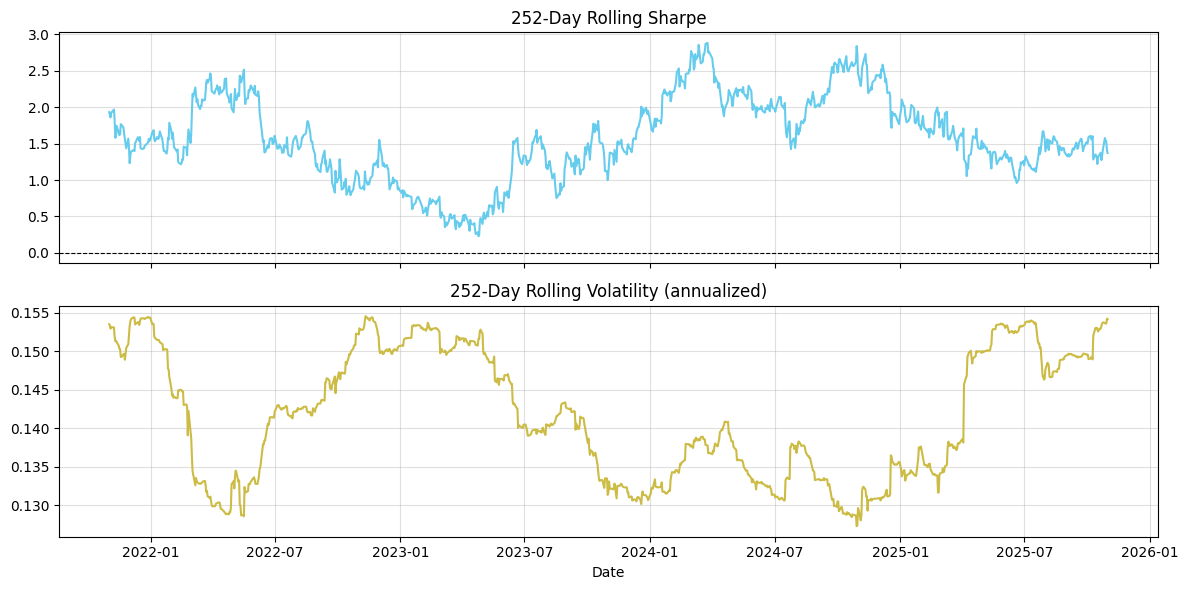

In [17]:
toolkit.plot_rolling_metrics(252)

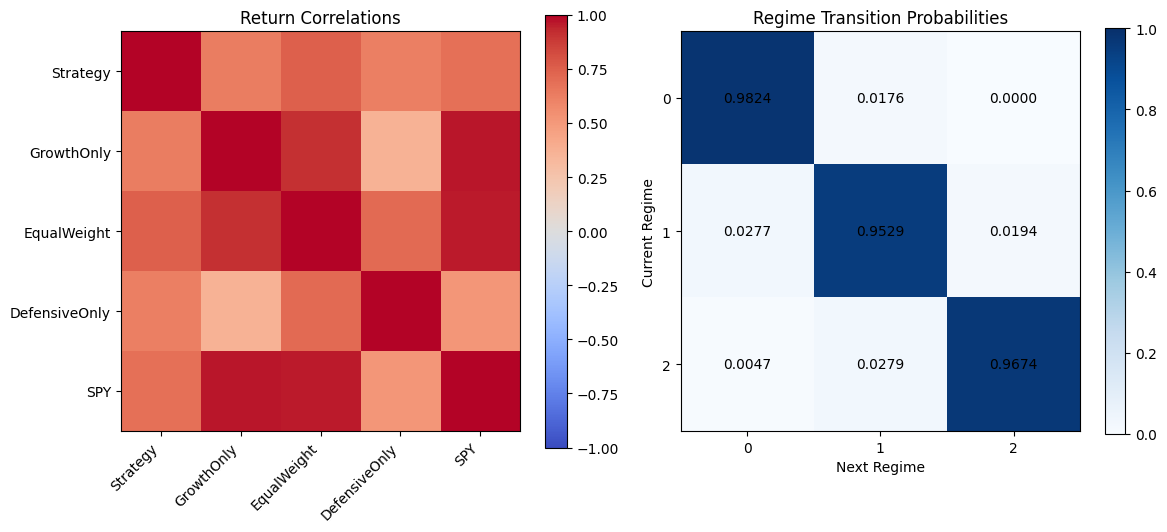

In [18]:
toolkit.plot_correlation_and_transitions()

## Grid Search for Hyperparameter Tunning

In [19]:
df = RegimeRotationStrategy.grid_search_regimes(
    growth,
    defensive,
    start_date="2019-05-09",
    windows=(36, 72, 120, 240, 360, 480),
    steps=(6, 12, 24, 48),
    refits=(12, 24, 48, 96, 120),
)
df

Output()

start_date    end_date  duration  \
p window step refit_every burn_in                                     
2 360    12   48          700      2020-10-30  2025-10-31      1827   
              96          700      2020-10-30  2025-10-31      1827   
              12          700      2020-10-30  2025-10-31      1827   
              24          700      2020-10-30  2025-10-31      1827   
              120         700      2020-10-30  2025-10-31      1827   
...                                       ...         ...       ...   
         48   120         700      2025-02-05  2025-10-31       268   
              12          700      2025-02-05  2025-10-31       268   
              24          700      2025-02-05  2025-10-31       268   
              48          700      2025-02-05  2025-10-31       268   
              96          700      2025-02-05  2025-10-31       268   

                                   cumulative_return  annual_return  \
p window step refit_every burn_in                                     
2 360    12   48          700               2.001889       0.246542   
              96          700               1.996152       0.246064   
              12          700               1.974975       0.244293   
              24          700               1.960896       0.243110   
              120         700               1.942908       0.241593   
...                                              ...            ...   
         48   120         700              -0.085331      -0.113253   
              12          700              -0.085331      -0.113253   
              24          700              -0.085331      -0.113253   
              48          700              -0.085331      -0.113253   
              96          700              -0.085331      -0.113253   

                                   annual_volatility    sharpe  max_drawdown  
p window step refit_every burn_in                                             
2 360    12   48          700               0.143343  1.719940     -0.119491  
              96          700               0.144193  1.706489     -0.119491  
              12          700               0.144371  1.692115     -0.119491  
              24          700               0.144235  1.685515     -0.119491  
              120         700               0.143715  1.681055     -0.119491  
...                                              ...       ...           ...  
         48   120         700               0.183944 -0.615692     -0.256127  
              12          700               0.183944 -0.615692     -0.256127  
              24          700               0.183944 -0.615692     -0.256127  
              48          700               0.183944 -0.615692     -0.256127  
              96          700               0.183944 -0.615692     -0.256127  

[120 rows x 8 columns]